# HW 1 - Carlos Alvarado

### Problem 1

In [2]:
import os
import pandas as pd
import requests

def get_and_load_data(data_info):
    '''
    Loads "data_name.csv" from local disk, or downloads it if it's not present
    
    Input: dictionary with information about required data
    Returns: pandas data_frame for "data_name"
    '''
    
    filepath = './data/{}.csv'.format(data_info['source'])
    
    if os.path.exists(filepath):
        data = pd.read_csv(filepath)
    else:
        data = helper_download_data(filepath, data_name)
    
    for old_var, new_var in data_info['rename']:
        data.rename(index=str, columns={old_var: new_var}, inplace=True)
        
    return data
    
def helper_download_data(filepath, data_name):
    offset = 0
    limit = 50000
    data = pd.DataFrame({})
    
    while True:
        
        url = 'https://data.cityofchicago.org/resource/{}.json?$limit={}&$offset={}'.format(
            data_name, limit, offset)
        print('getting data from', url)
    
        response = requests.get(url)
        response_code = response.status_code
        
        if response_code != 200: 
            print('Failed to download data')
            break
            
        json_data = response.content

        if len(json_data) > 4:
            data = pd.concat([data, pd.read_json(json_data)])
        
            offset = offset + limit
        else:
            print(json_data)
            break
            
    #save data to csv for future use
    data.to_csv(filepath)
    
    return data
    

In [25]:
DATA1 = {'name': 'Graffiti Removal',
         'source': 'hec5-y4x5',
         'rename': [('where_is_the_graffiti_located_', 'Sub Type')]    
        }

DATA2 = {'name': 'Vacant and Abandoned Buildings Reported',
         'source': '7nii-7srd',
         'rename': [('is_building_open_or_boarded_', 'Sub Type'), 
                    ('date_service_request_was_received', 'creation_date')]
        }

DATA3 = {'name': 'Pot Holes Reported',
         'source': '7as2-ds3y',
         'rename': [('zip', 'zip_code'), 
                    ('type_of_service_request', 'Sub Type')]
        }
    
DATA4 = {'name': 'Sanitation Code Complaints',
         'source': 'me59-5fac',
         'rename': [('what_is_the_nature_of_this_code_violation_', 'Sub Type')]
        }

SOURCES = [DATA1, DATA2, DATA3, DATA4]

complaints = pd.DataFrame({})

for db_data in SOURCES:
    data = get_and_load_data(db_data)
    print(data.columns)
    data['Complaint Type'] = db_data['name']
    complaints = pd.concat([complaints, data], ignore_index=True)

complaints.sample(1000).to_csv('./data/sample.csv')



Index(['Unnamed: 0', 'community_area', 'completion_date', 'creation_date',
       'latitude', 'location', 'longitude', 'police_district',
       'service_request_number', 'ssa', 'status', 'street_address',
       'type_of_service_request', 'ward',
       'what_type_of_surface_is_the_graffiti_on_', 'Sub Type', 'x_coordinate',
       'y_coordinate', 'zip_code'],
      dtype='object')
Index(['Unnamed: 0', 'address_street_direction', 'address_street_name',
       'address_street_number', 'address_street_suffix',
       'any_people_using_property_homeless_childen_gangs_', 'community_area',
       'creation_date', 'if_the_building_is_open_where_is_the_entry_point_',
       'Sub Type', 'is_the_building_currently_vacant_or_occupied_',
       'is_the_building_dangerous_or_hazardous_',
       'is_the_building_vacant_due_to_fire_', 'latitude', 'location',
       'location_of_building_on_the_lot_if_garage_change_type_code_to_bgd_',
       'longitude', 'police_district', 'service_request_number',
 

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
complaints.loc[10]

In [ ]:
ctcounts = complaints['Complaint Type'].value_counts()
ctcounts

In [ ]:
gb = complaints.groupby(['Complaint Type', 'Sub Type']).size().to_frame()
print(gb)

In [ ]:
gb_community_area = complaints.groupby(['Complaint Type', 'community_area']).size().to_frame()
select = gb_community_area['0'] 
print(gb_community_area)

### Problem 2

In [34]:
import geopandas as gpd
import os

data_pth = "./data/boundaries/"
#data_pth = "./data/cb_2015_17_bg_500k/"
data1_name = "geo_export_cdf3020f-dc9a-4e8b-ab13-a2db8609750f.shp"
data2_name = "cb_2015_17_bg_500k.shp"

blocks = gpd.read_file(os.path.join(data_pth, data1_name))
len(blocks)

46357

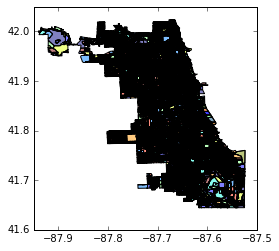

In [35]:
%matplotlib inline
import matplotlib
blocks.plot();

In [26]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point

#complaints = pd.read_csv('./data/sample.csv')

geometry = [Point(xy) for xy in zip(complaints.longitude, complaints.latitude)]
geo_complaints = complaints.drop(['latitude', 'longitude'], axis=1)
crs = {'init': 'epsg:4269'}
geo_complaints = GeoDataFrame(geo_complaints, crs=crs, geometry=geometry)
geo_complaints.head(1).geometry

0    POINT (-87.67258908007462 41.82667996575032)
Name: geometry, dtype: object

In [3]:
geo_complaints.geometry[:5]

0    POINT (-87.62398757521471 41.89752669856311)
1    POINT (-87.69095886166781 41.82105560481256)
2     POINT (-87.73100420024738 41.8479242100189)
3    POINT (-87.65809289527267 41.77218734497791)
4    POINT (-87.70421646490921 41.94329691488169)
Name: geometry, dtype: object

In [33]:
len(list(blocks['COUNTYFP'].value_counts()))

102

In [27]:
from geopandas.tools import sjoin
data_with_blockid = sjoin(geo_complaints, blocks, how="left")

RTreeError: Coordinates must not have minimums more than maximums

In [28]:
geo_complaints['ward'].value_counts()

14    78215
1     60640
25    59260
12    57480
35    50724
32    47427
23    47141
11    45785
33    45585
22    43190
47    41369
31    39631
30    37110
27    35428
13    33227
10    31859
26    31751
42    30025
39    29099
16    28870
2     28825
40    28141
45    28138
28    27477
38    26879
15    26455
50    26297
18    24693
36    23421
43    22228
49    20943
44    20883
29    20852
24    20278
41    20076
21    20002
34    19713
8     19457
37    19206
17    19122
6     18655
20    17180
19    16797
9     16144
48    16055
7     15722
46    13859
3     13791
5     12961
4      9478
0      1585
Name: ward, dtype: int64

In [29]:
import sys, traceback

for community in sorted(list(geo_complaints['ward'].value_counts().index)):
    sel_data = geo_complaints['ward'] == community
    data = geo_complaints[sel_data]
    print(len(data))
    try:
        data_with_blockid = sjoin(data, blocks, how="left")
        print('OK!')
        print(data_with_blockid.iloc[10])
    except:
        traceback.print_exc(file=sys.stdout)
        print(data['ward'].value_counts())
        print('FAILED')

1585
Traceback (most recent call last):
  File "<ipython-input-29-90a57439229a>", line 8, in <module>
    data_with_blockid = sjoin(data, blocks, how="left")
  File "/home/calvarado/.local/lib/python3.4/site-packages/geopandas/tools/sjoin.py", line 54, in sjoin
    .apply(lambda x: list(tree_idx.intersection(x))))
  File "/usr/local/lib/python3.4/dist-packages/pandas/core/series.py", line 2169, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/src/inference.pyx", line 1059, in pandas.lib.map_infer (pandas/lib.c:62578)
  File "/home/calvarado/.local/lib/python3.4/site-packages/geopandas/tools/sjoin.py", line 54, in <lambda>
    .apply(lambda x: list(tree_idx.intersection(x))))
  File "/home/calvarado/.local/lib/python3.4/site-packages/rtree/index.py", line 454, in intersection
    p_mins, p_maxs = self.get_coordinate_pointers(coordinates)
  File "/home/calvarado/.local/lib/python3.4/site-packages/rtree/index.py", line 320, in get_coordinate_pointers
  

### Problem 3